# E-Commerce Analysis

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



# Functions

In [13]:
def check_nulls_dupes(df):
  print(f"The amount of Null values: {df.isna().sum()}")
  print(f"The amount of Dupe values: {df.duplicated().sum()}")

def check_class_imbalance(target):
  
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(15, 10))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.show()
  
  plt.figure(figsize=(18, 12))
  sns.countplot(x=target)
  plt.xlabel("Target Class Breakdown")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.show()

# EDA Analysis

In [3]:
df = pd.read_csv("/Users/maukanmir/Downloads/ecommerce_product_dataset.csv")
df

,ProductID,ProductName,Category,Price,Rating,NumReviews,StockQuantity,Discount,Sales,DateAdded
0,1,Headphones,Electronics,400.31,1.7,3772,20,0.08,466,2023-11-08
1,2,Headphones,Electronics,235.03,2.3,2919,663,0.33,1332,2023-09-26
2,3,Smartwatch,Electronics,417.90,1.8,1184,459,0.31,252,2023-10-18
3,4,Smartphone,Electronics,152.70,3.4,2047,475,0.49,1806,2023-12-03
4,5,Laptop,Electronics,394.74,1.8,1267,831,0.23,1508,2023-08-08
...,...,...,...,...,...,...,...,...,...,...
995,996,Throw Blanket,Blankets,207.72,2.3,1973,16,0.46,325,2024-02-11
996,997,Fleece Blanket,Blankets,268.60,3.2,841,201,0.39,1546,2023-06-29
997,998,Throw Blanket,Blankets,92.74,2.8,3454,880,0.02,1295,2023-10-27
998,999,Weighted Blanket,Blankets,152.28,1.3,2850,752,0.34,1962,2023-10-26


# Check For Nulls and Dupes

In [6]:
check_nulls_dupes(df)

The amount of Null values: ProductID        0
ProductName      0
Category         0
Price            0
Rating           0
NumReviews       0
StockQuantity    0
Discount         0
Sales            0
DateAdded        0
dtype: int64
The amount of Dupe values: 0


# Check Class Imbalance

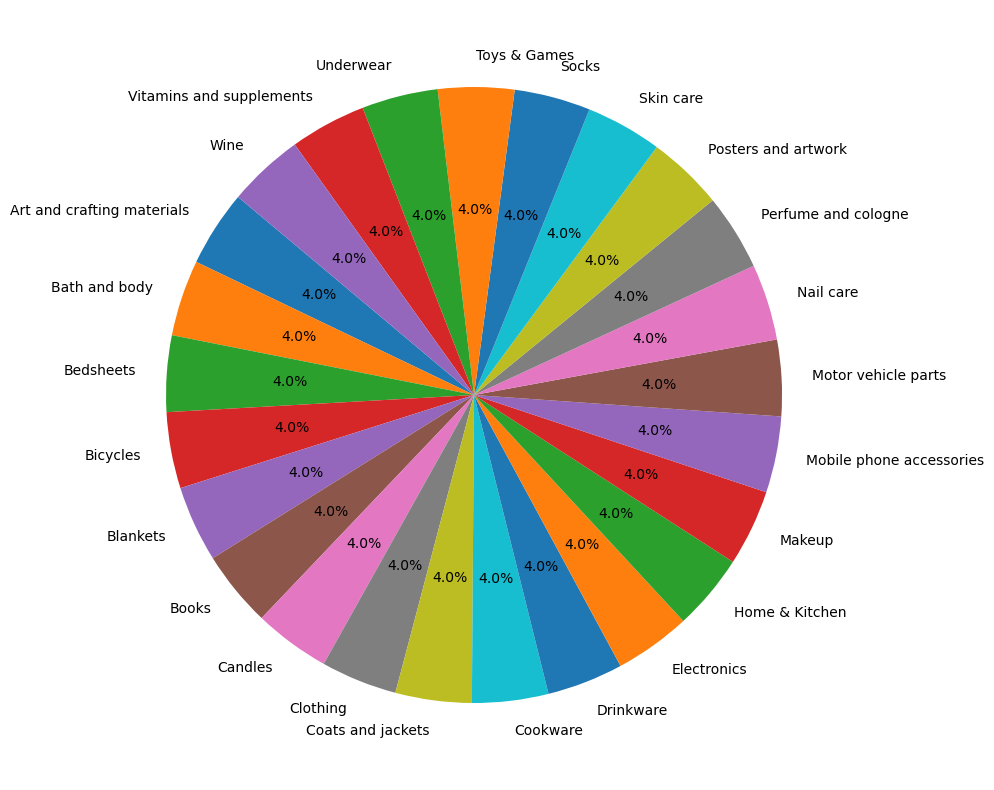

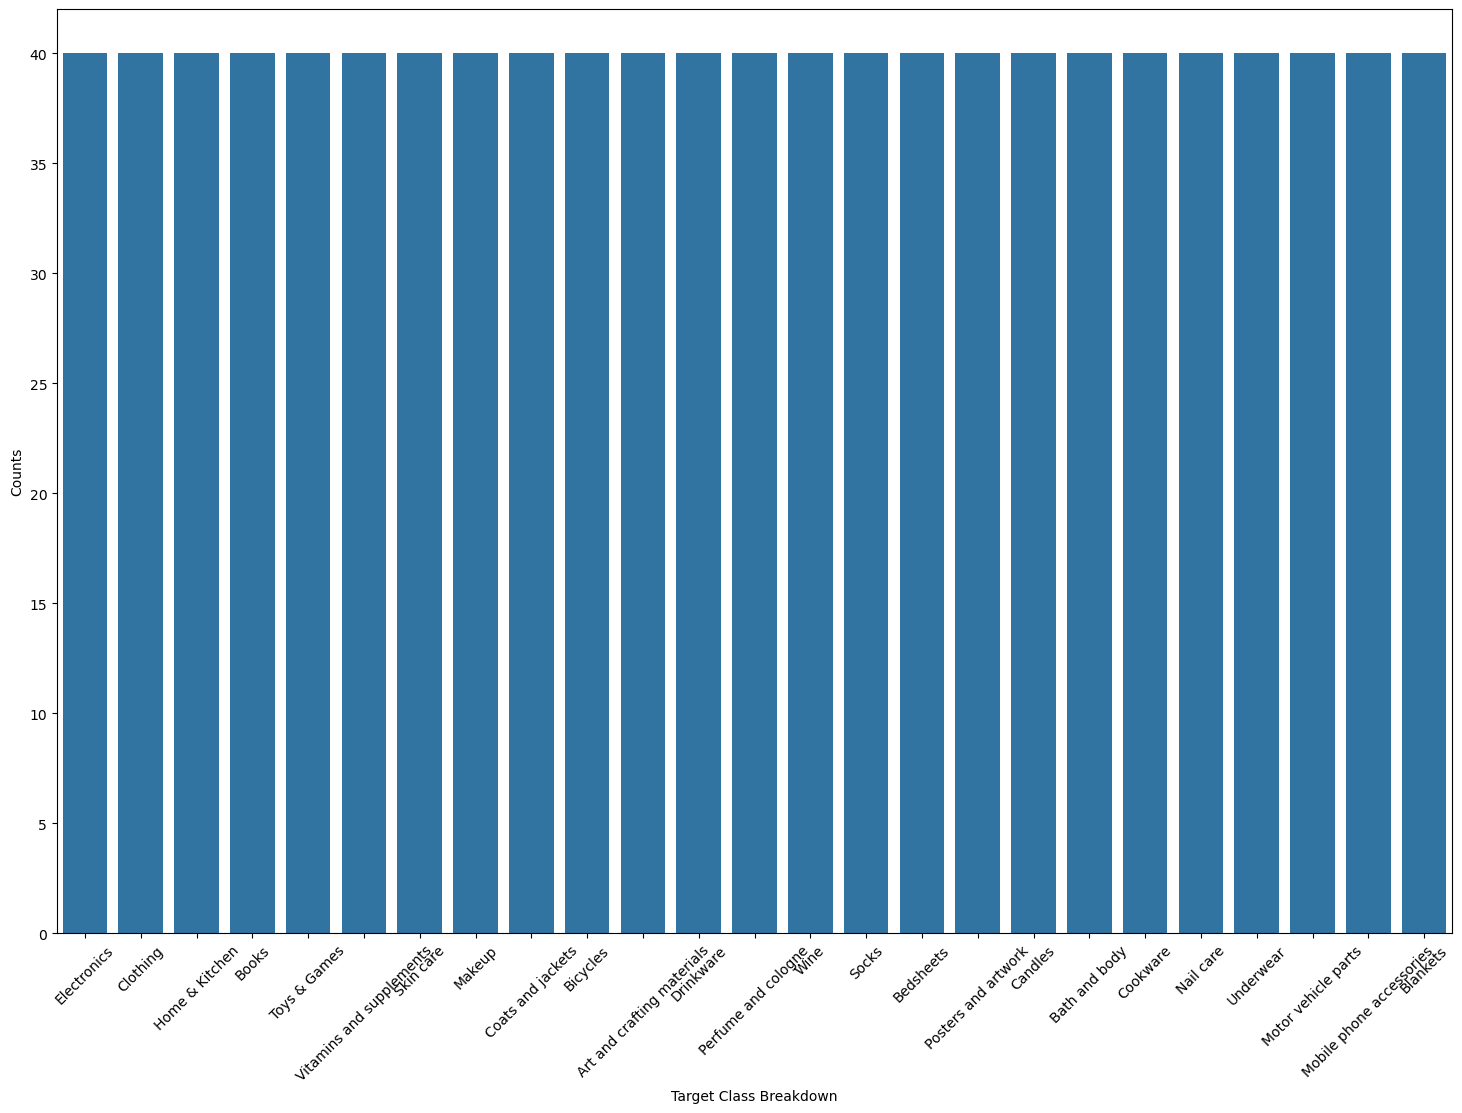

In [14]:
check_class_imbalance(df["Category"])

# We Have a Category Balance

# I think we might be able to narrow the amount of categories down into smaller categories, maybe for health, home, etc. We will have to explore this after some eda analysis

In [15]:
df.dtypes

ProductID          int64
ProductName       object
Category          object
Price            float64
Rating           float64
NumReviews         int64
StockQuantity      int64
Discount         float64
Sales              int64
DateAdded         object
dtype: object

In [16]:
df.describe()

,ProductID,Price,Rating,NumReviews,StockQuantity,Discount,Sales
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,253.77551,3.025600,2498.753000,495.395000,0.251640,1011.037000
std,288.819436,141.40362,1.151004,1463.241871,292.799253,0.146455,582.113466
min,1.000000,10.11000,1.000000,3.000000,0.000000,0.000000,0.000000
25%,250.750000,133.09250,2.100000,1201.750000,241.750000,0.130000,502.000000
50%,500.500000,251.31000,3.100000,2476.000000,505.000000,0.250000,998.000000
75%,750.250000,375.82750,4.000000,3797.500000,743.500000,0.380000,1540.000000
max,1000.000000,499.74000,5.000000,4994.000000,993.000000,0.500000,1997.000000


In [21]:
df.drop("ProductID", axis=1, inplace=True)

In [24]:
df["ProductName"].value_counts()

Biography        22
Mountain Bike    19
Throw Blanket    18
Denim Jacket     17
Vitamin D        15
                 ..
Rain Jacket       5
Winter Coat       5
Cuticle Oil       5
Fantasy Book      4
Pillar Candle     4
Name: ProductName, Length: 100, dtype: int64

# Change Object column to Datetime

In [27]:
df["DateAdded"] = pd.to_datetime(df["DateAdded"])
columns = ["year", "day", "month", "hour"]

for col in columns:
  df[col] = getattr(df["DateAdded"].dt, col)

In [29]:
df.drop("DateAdded", inplace=True, axis=1)

df["year"].value_counts()

2023    575
2024    425
Name: year, dtype: int64

# Visual Analysis

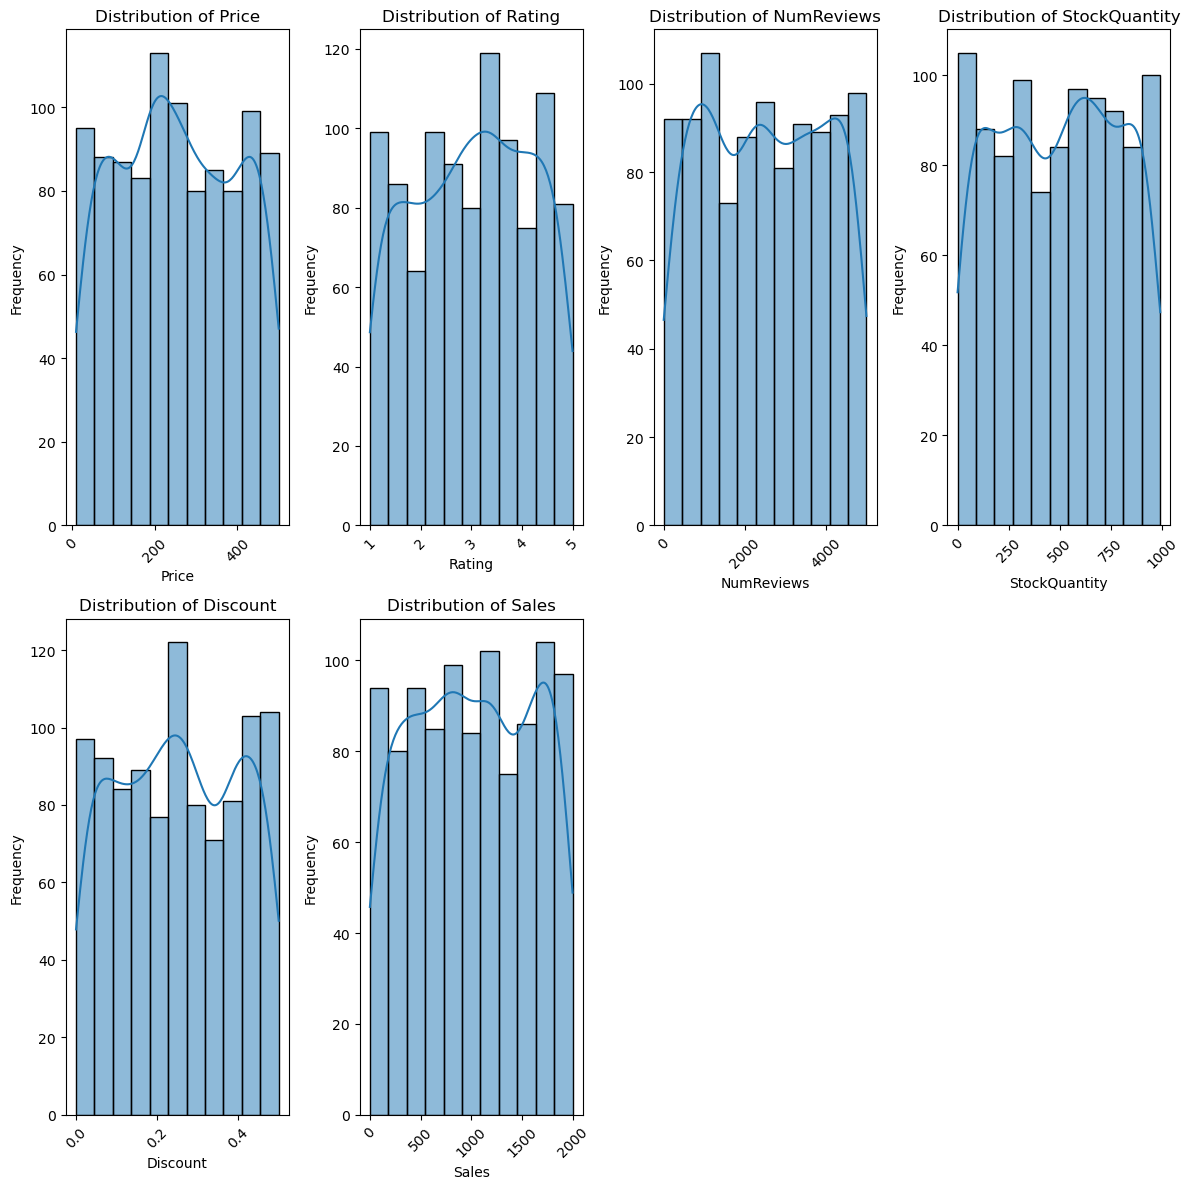

In [33]:
interested_columns = ["Price", "Rating", "NumReviews", "StockQuantity", "Discount", "Sales"]

plt.figure(figsize=(12, 12))
rows = len(interested_columns)
dims = (rows+3)//4

for idx, col in enumerate(interested_columns):
  plt.subplot(dims, 4, idx+1)
  plt.title(f"Distribution of {col}")
  sns.histplot(df[col], kde=True)
  plt.xlabel(col)
  plt.ylabel("Frequency")
  plt.xticks(rotation=45)

plt.tight_layout()
plt.show()